The aim of this project is to create a compact, highly customizable and easy to use synthesis function that is capable of additive synthesis, substractive synthesis and frequency modulation. The project also offers multiple customisable envelope functions that can generate amplitude and filter envelopes, as well as functions that can apply these envelopes to the synthesized signals, combine signal or envelope parameters to get more complex results, and much more. As it currently stands, the project is fundamentally a work in progress, however it has all the necessary tools for the intended functionalities to work and can therefore be used without any issues.

As part of the learning experience, one of the main premises of this project is to not use any modules other than NumPy in the main part of the code. The remaining modules are imported only for the purposes of visualizing the data and for creating audio playbacks. The following "help" functions are meant to be used as references to eliminate the need to scroll upwards:
- help_building_blocks() : returns a text containing the parameters of the building block functions along with the default values of these parameters
- help_parameters() : returns a text containing the parameters of the shaping block functions

In [1]:
import numpy as np

import matplotlib.pyplot as plt
from scipy.io.wavfile import write
import IPython.display as ipd

fsample = 44100
samplerate = 1 / fsample

In [2]:
def help_building_blocks():
    print('''
    save_filter                 :    name, filter_type, *pars, **kwpars
    save_envelope               :    name, envelope_type, *pars, **kwpars
    save_parameter_values       :    name, value_type, *pars, **kwpars
    
    signal_to_filter_parameters :    name, signal, is_envelope = False
    parameter_to_filter         :    name, parameter_name, len_filter, save = True, get_output = False
    parameter_to_envelope       :    name, parameter_name, len_envelope, save = True, get_output = False
    
    combine_filters             :    name, filters_list, len_filter, A_mult = 1, save = True, get_output = False
    combine_envelopes           :    name, envelopes_list, len_envelope, A_mult = 1, save = True, get_output = False
    
    sum_filters                 :    name, filters_list, A_mult = 1, save = True, get_output = False
    sum_envelopes               :    name, envelopes_list, A_mult = 1, save = True, get_output = False
    sum_signals                 :    name, signals_list, A_mult = 1, save = True, get_output = False
    
    create_adsr                 :    name, len_adsr, crop = False, y0 = 0.25, y1 = 1.25, y2 = 1, y3 = 0.9, y4 = 0,
                                           a_len = 0.0125, a_exp = 1.25, d_len = 0.0125, d_exp = 0.25,
                                           s_len = 0.95, s_exp = 1, r_len = 0.025, r_exp = 5, save = True, get_output = False
    
    apply_envelope_parameters   :    name, signal, envelope, save = True, get_output = False
    apply_envelope              :    name, signal, envelope, save = True, get_output = False
    
    create_partials_list        :    name, partials_list
    create_partials             :    name, K_min, K_max, K_len, function = "lopass_sig"
    
    create_signal               :    name, f, waveform = "sin", T = 1, A = 1, phi = 1, additive_1 = 0, fm_1 = 0,
                                           filter_type = 0, filter_1 = 0, filter_2 = 0, save = True, get_output = False
    ''')

In [3]:
def help_parameters():
    print('''
    signal                      :    f, waveform, T, A, phi, additive_1, fm_1, filter_type, filter_1, filter_2, is_envelope
    
    hipass_lin                  :    x_min, x_max, y_min, y_max, is_envelope
    lopass_lin                  :    x_min, x_max, y_min, y_max, is_envelope
    
    bandpass_lin                :    y_min_1, y_min_2, y_max, x_1, x_2, x_3, x_4, is_envelope
    bandreject_lin              :    y_min, y_max_1, y_max_2, x_1, x_2, x_3, x_4, is_envelope
    
    hipass_sig                  :    s, k, x_0, H, A, A_max, cutoff_in_hertz, is_envelope
    lopass_sig                  :    s, k, x_0, H, A, A_max, cutoff_in_hertz, is_envelope
    
    gauss_res                   :    L, x_0, H, A, A_min, A_max, cutoff_in_hertz, is_envelope
    gauss_rej                   :    L, x_0, H, A, A_min, A_max, cutoff_in_hertz, is_envelope

    adsr                        :    crop, y0, y1, y2, y3, y4, a_len, a_exp, d_len, d_exp, s_len, s_exp, r_len, r_exp
    
    additive_1                  :    K, f_n, A_n, phi_n
    
    fm_1                        :    f_m, waveform_m, A_m, phi_m, use_mod_index, mod_index
    ''')

The most fundamental aspect of this project is that it heavily relies on a save feature, not only for signals/envelopes that are defined over a time domain but also for parameters that can be called whenever needed. This makes it easier to use the same parameters for signals/envelopes with differing lengths. The directories are defined as dictionaries, and the saved data will be stored as a dictionary inside the corresponding directory.

As a general rule of thumb, if a function requires a name parameter, then its output can be saved in its corresponding directory. Giving a different name to each saved data set is not necessary, but highly recommended. If a function has an output parameter, then this function can either return its output in the form of a list or a NumPy array depending on the function, save it in the corresponding directory, or both. If a function doesn't have an output parameter but it supports an unoptional save feature, then this function serves the purpose of saving parameters that can be called by another function.

While it certainly is not the only approach, the encouraged way to use the code provided in this project is as follows: save the parameters of multiple shaping blocks, create complex building blocks using the shaping blocks if necessary, and put everything in the synthesis function. While most functions are self-explanatory from the way they are defined, it is encouraged to test their parameters in an external plotting software. This not only makes the troubleshooting process easier, but also enables a creative approach towards certain problems.

Moving on with the general features, some functions also support an indefinite amount of optional parameters, meaning that those functions will need to call default parameters to function as intended. The following dictonaries serve this exact purpose. An indefinite amount of optional parameters makes a function compatible with multiple features without having to define all of them individually or without having to create nested if statements. It is also more convenient to use in situations where only few parameters are in need of change.

In the following, the last dictionary and the following tuples have the purpose of failsafing the eval() function used in the save functions. The whitelist tuples make sure that the eval() function only accepts values inside these tuples, while the dictionary defines the directory of the parameters that are to be saved.

In [4]:
saved_signals = {}
saved_signal_parameters = {}
saved_partials = {}
saved_additive_1_parameters = {}
saved_fm_1_parameters = {}
saved_filters = {}
saved_filter_parameters = {}
saved_envelopes = {}
saved_envelope_parameters = {}

filter_defaults = {
    "hipass_lin": {"x_min": 0, "x_max": 1, "y_min": 0, "y_max": 1, "is_envelope": False},
    "lopass_lin": {"x_min": 0, "x_max": 1, "y_min": 0, "y_max": 1, "is_envelope": False},
    "bandpass_lin": {"y_min_1": 0, "y_min_2": 0, "y_max": 1, "x_1": 0, "x_2": 1/3, "x_3": 2/3, "x_4": 1, "is_envelope": False},
    "bandreject_lin": {"y_min": 0, "y_max_1": 1, "y_max_2": 1, "x_1": 0, "x_2": 1/3, "x_3": 2/3, "x_4": 1, "is_envelope": False},
    "hipass_sig": {"s": 0, "k": 1, "x_0": 0, "H": 0, "A": 1, "A_max": 1, "cutoff_in_hertz": True, "is_envelope": False},
    "lopass_sig": {"s": 0, "k": 1, "x_0": 0, "H": 0, "A": 1, "A_max": 1, "cutoff_in_hertz": True, "is_envelope": False},
    "gauss_res": {"L": 1, "x_0": 0, "H": 0, "A": 1, "A_min": 0, "A_max": 1, "cutoff_in_hertz": True, "is_envelope": False},
    "gauss_rej": {"L": 1, "x_0": 0, "H": 0, "A": 1, "A_min": 0, "A_max": 1, "cutoff_in_hertz": True, "is_envelope": False},
    "signal": {"f": 1, "waveform": "sin", "T": 1, "A": 1, "phi": 1, "additive_1": 0, "fm_1": 0, "filter_type": 0, "filter_1": 0, "filter_2": 0, "is_envelope": False}
    }
envelope_defaults = {
    "hipass_lin": {"x_min": 0, "x_max": 1, "y_min": 0, "y_max": 1, "is_envelope": True},
    "lopass_lin": {"x_min": 0, "x_max": 1, "y_min": 0, "y_max": 1, "is_envelope": True},
    "bandpass_lin": {"y_min_1": 0, "y_min_2": 0, "y_max": 1, "x_1": 0, "x_2": 1/3, "x_3": 2/3, "x_4": 1, "is_envelope": True},
    "bandreject_lin": {"y_min": 0, "y_max_1": 1, "y_max_2": 1, "x_1": 0, "x_2": 1/3, "x_3": 2/3, "x_4": 1, "is_envelope": True},
    "hipass_sig": {"s": 0, "k": 1, "x_0": 0, "H": 0, "A": 1, "A_max": 1, "cutoff_in_hertz": True, "is_envelope": True},
    "lopass_sig": {"s": 0, "k": 1, "x_0": 0, "H": 0, "A": 1, "A_max": 1, "cutoff_in_hertz": True, "is_envelope": True},
    "gauss_res": {"L": 1, "x_0": 0, "H": 0, "A": 1, "A_min": 0, "A_max": 1, "cutoff_in_hertz": True, "is_envelope": True},
    "gauss_rej": {"L": 1, "x_0": 0, "H": 0, "A": 1, "A_min": 0, "A_max": 1, "cutoff_in_hertz": True, "is_envelope": True},
    "signal": {"f": 1, "waveform": "sin", "T": 1, "A": 1, "phi": 1, "additive_1": 0, "fm_1": 0, "filter_type": 0, "filter_1": 0, "filter_2": 0, "is_envelope": True},
    "adsr": {"crop": False, "y0": 0.25, "y1": 1.25, "y2": 1, "y3": 0.9, "y4": 0, "a_len": 0.0125, "a_exp": 1.25, "d_len": 0.0125, "d_exp": 0.25, "s_len": 0.95, "s_exp": 1, "r_len": 0.025, "r_exp": 5}
    }
value_defaults = {
    "signal": {"f": 1, "waveform": "sin", "T": 1, "A": 1, "phi": 1, "additive_1": 0, "fm_1": 0, "filter_type": 0, "filter_1": 0, "filter_2": 0},
    "additive_1": {"K": 1, "f_n": 1, "A_n": 0, "phi_n": 0},
    "fm_1": {"f_m": 1, "waveform_m": "sin", "A_m": 0, "phi_m": 0, "use_mod_index": False, "mod_index": 0}
    }

values_directory = {"signal": "saved_signal_parameters", "partials": "saved_partials", "additive_1": "saved_additive_1_parameters", "fm_1": "saved_fm_1_parameters"}

eval_whitelist = ("saved_signal_parameters", "saved_additive_1_parameters", "saved_fm_1_parameters", "saved_filter_parameters", "saved_partials", "saved_envelope_parameters")
eval_whitelist_2 = ("saved_signals", "saved_filters", "saved_envelopes")
filters_whitelist = ("hipass_lin", "lopass_lin", "bandpass_lin", "bandreject_lin", "hipass_sig", "lopass_sig", "gauss_res", "gauss_rej", "signal", "adsr")
values_whitelist = ("signal", "additive_1", "fm_1")


The signal() function defines the waveform of the signal. It is meant to be used inside other functions. For using the same functionalities in a way that is compatible with rest of the project, please use the create_simple_signal() function.

In [5]:
def signal(f, waveform = "sin", T = 1, A = 1, phi = 1):

    t = np.arange(0, T, samplerate)
    
    if waveform == "sin":
        wave = A * np.cos(2 * np.pi * f * t - 2 * np.pi * phi)
    elif waveform == "squ":
        wave = A * np.sign(np.cos(2 * np.pi * f * t - 2 * np.pi * phi))
    elif waveform == "tri":
        wave = 2 * abs(A - 2 * A * ((t - (phi / f)) % (1 / f)) * f) - A
    elif waveform == "saw":
        wave = A - 2 * A * ((t - (phi / f))  % (1 / f)) * f
    elif waveform == "saw_rise":
        wave = -(A - 2 * A * ((t - (phi / f))  % (1 / f)) * f)
    elif waveform == "rnd":
        wave = np.random.normal(0, (np.exp(-0.5 / (A**2))) / (A * np.sqrt(2 * np.pi)), len(t))
    return wave


In [6]:
def create_simple_signal(name, f, waveform = "sin", T = 1, A = 1, phi = 1, save = True, get_output = False):
    custom_wave = signal(f, waveform, T, A, phi)
    return fn_output_check(name, save, get_output, custom_wave, saved_signals)

Below are the primary shaping block functions of the project. They return a linear, a sigmoid, or a gaussian output list depending on the function. If is_envelope is set to False, the output is extended by its mirror image and the 0 point is set to have the value of 0, which implies its use as a filter envelope. If is_envelope is set to True, then the values remain unchanged, which implies its use as an amplitude envelope. Note that while these functions are also meant to be used inside other functions, plotting their outputs for testing purposes has its practical uses.

In [7]:
def hipass_lin(filter_len, is_envelope = False, x_min = 0, x_max = 1, y_min = 0, y_max = 1):
    
    filter_pos = []
    filter_neg = []
    filter_sum = [0]
    len_filter = filter_len

    if is_envelope == False:
        filter_len = int(filter_len / 2)

    X_list = [x_min, x_max]
    X_list.sort()

    X_max = X_list[1] * filter_len
    X_min = X_list[0] * filter_len

    Y_list = [y_min, y_max]
    Y_list.sort()

    y_min = Y_list[0]
    y_max = Y_list[1]

    for n in range(filter_len):
        if (n + 1) < X_min:
            hipass_pos = y_min
        elif (n + 1) > X_max:
            hipass_pos = y_max
        else:
            hipass_pos = y_min + (y_max - y_min) * (n - X_min) / (X_max - X_min)
        filter_pos.append(hipass_pos)

    filter_neg.extend(filter_pos)
    filter_neg.reverse()
    filter_sum.extend(filter_pos)
    if is_envelope == False:
        if (len_filter % 2) == 0:
            del filter_sum[-1]
        filter_sum.extend(filter_neg)
    else:
        del filter_sum[0]

    return filter_sum


In [8]:
def lopass_lin(filter_len, is_envelope = False, x_min = 0, x_max = 1, y_min = 0, y_max = 1):

    filter_pos = []
    filter_neg = []
    filter_sum = [0]
    len_filter = filter_len

    if is_envelope == False:
        filter_len = int(filter_len / 2)

    X_list = [x_min, x_max]
    X_list.sort()

    X_max = X_list[1] * filter_len
    X_min = X_list[0] * filter_len

    Y_list = [y_min, y_max]
    Y_list.sort()

    y_min = Y_list[1]
    y_max = Y_list[0]

    for n in range(filter_len):
        if (n + 1) < X_min:
            hipass_pos = y_min
        elif (n + 1) > X_max:
            hipass_pos = y_max
        else:
            hipass_pos = y_min + (y_max - y_min) * (n - X_min) / (X_max - X_min)
        filter_pos.append(hipass_pos)

    filter_neg.extend(filter_pos)
    filter_neg.reverse()
    filter_sum.extend(filter_pos)
    if is_envelope == False:
        if (len_filter % 2) == 0:
            del filter_sum[-1]
        filter_sum.extend(filter_neg)
    else:
        del filter_sum[0]

    return filter_sum


In [9]:
def bandpass_lin(filter_len, is_envelope = False, y_min_1 = 0, y_min_2 = 0, y_max = 1, x_1 = 0, x_2 = 1/3, x_3 = 2/3, x_4 = 1):

    filter_pos = []
    filter_neg = []
    filter_sum = [0]
    len_filter = filter_len

    if is_envelope == False:
        filter_len = int(filter_len / 2)

    X_list = [x_1, x_2, x_3, x_4]
    X_list.sort()

    X_1 = X_list[0] * filter_len
    X_2 = X_list[1] * filter_len
    X_3 = X_list[2] * filter_len
    X_4 = X_list[3] * filter_len

    Y_list = [y_min_1, y_max]
    Y_list.sort()
    y_min_1 = Y_list[0]
    y_max = Y_list[1]

    Y_list = [y_min_2, y_max]
    Y_list.sort()
    y_min_2 = Y_list[0]
    y_max = Y_list[1]

    for n in range(filter_len):
        if (n + 1) < X_1: # less than minimum
            bandpass_pos = y_min_1
        elif X_4 < (n + 1): # greater than maximum
            bandpass_pos = y_min_2
        elif X_2 <= (n + 1) <= X_3: # in between 2 maxima
            bandpass_pos = y_max
        elif X_1 <= (n + 1) < X_2: # rising slope
            bandpass_pos = y_min_1 + (y_max - y_min_1) * (n - X_1) / (X_2 - X_1)
        else: # falling slope
            bandpass_pos = y_max + (y_min_2 - y_max) * (n - X_3) / (X_4 - X_3)
        filter_pos.append(bandpass_pos)

    filter_neg.extend(filter_pos)
    filter_neg.reverse()
    filter_sum.extend(filter_pos)
    if is_envelope == False:
        if (len_filter % 2) == 0:
            del filter_sum[-1]
        filter_sum.extend(filter_neg)
    else:
        del filter_sum[0]

    return filter_sum

In [10]:
def bandreject_lin(filter_len, is_envelope = False, y_min = 0, y_max_1 = 1, y_max_2 = 1, x_1 = 0, x_2 = 1/3, x_3 = 2/3, x_4 = 1):

    filter_pos = []
    filter_neg = []
    filter_sum = [0]
    len_filter = filter_len

    if is_envelope == False:
        filter_len = int(filter_len / 2)

    X_list = [x_1, x_2, x_3, x_4]
    X_list.sort()

    X_1 = X_list[0] * filter_len
    X_2 = X_list[1] * filter_len
    X_3 = X_list[2] * filter_len
    X_4 = X_list[3] * filter_len

    Y_list = [y_min, y_max_1]
    Y_list.sort()
    y_min = Y_list[0]
    y_max_1 = Y_list[1]

    Y_list = [y_min, y_max_2]
    Y_list.sort()
    y_min = Y_list[0]
    y_max_2 = Y_list[1]

    for n in range(filter_len):
        if (n + 1) < X_1: # less than minimum
            bandpass_pos = y_max_1
        elif X_4 < (n + 1): # greater than maximum
            bandpass_pos = y_max_2
        elif X_2 <= (n + 1) <= X_3: # in between 2 minima
            bandpass_pos = y_min
        elif X_1 <= (n + 1) < X_2: # rising slope
            bandpass_pos = y_max_1 + (y_min - y_max_1) * (n - X_1) / (X_2 - X_1)
        else: # falling slope
            bandpass_pos = y_min + (y_max_2 - y_min) * (n - X_3) / (X_4 - X_3)
        filter_pos.append(bandpass_pos)

    filter_neg.extend(filter_pos)
    filter_neg.reverse()
    filter_sum.extend(filter_pos)
    if is_envelope == False:
        if (len_filter % 2) == 0:
            del filter_sum[-1]
        filter_sum.extend(filter_neg)
    else:
        del filter_sum[0]

    return filter_sum

In [11]:
def hipass_sig(filter_len, is_envelope = False, s = 0, k = 1, x_0 = 0, H = 0, A = 1, A_max = 1, cutoff_in_hertz = True):

    filter_pos = []
    filter_neg = []
    filter_sum = [0]
    len_filter = filter_len

    if is_envelope == False:
        filter_len = int(filter_len / 2)

    if cutoff_in_hertz == True:
        x0 = -0.625 + x_0 / filter_len
        
    else:
        x0 = x_0

    for n in range(filter_len):
        hipass_pos = A / (1 + np.e ** (-2 * np.e * k * (2 * n / filter_len - 2 * x0 - 1))) ** (1 / (1 + s ** np.e)) + A * H
        if hipass_pos >= A_max:
            filter_pos.append(A_max)
        elif hipass_pos <= 0:
            filter_pos.append(0)
        else:
            filter_pos.append(hipass_pos)

    filter_neg.extend(filter_pos)
    filter_neg.reverse()
    filter_sum.extend(filter_pos)
    if is_envelope == False:
        if (len_filter % 2) == 0:
            del filter_sum[-1]
        filter_sum.extend(filter_neg)
    else:
        del filter_sum[0]

    return filter_sum


In [12]:
def lopass_sig(filter_len, is_envelope = False, s = 0, k = 1, x_0 = 0, H = 0, A = 1, A_max = 1, cutoff_in_hertz = True):

    filter_pos = []
    filter_neg = []
    filter_sum = [0]
    len_filter = filter_len

    if is_envelope == False:
        filter_len = int(filter_len / 2)

    k = -k

    if cutoff_in_hertz == True:
        x0 = -0.375 + x_0 / filter_len
    else:
        x0 = x_0

    for n in range(filter_len):
        hipass_pos = A / (1 + np.e ** (-2 * np.e * k * (2 * n / filter_len - 2 * x0 - 1))) ** (1 / (1 + s ** np.e)) + A * H
        if hipass_pos >= A_max:
            filter_pos.append(A_max)
        elif hipass_pos <= 0:
            filter_pos.append(0)
        else:
            filter_pos.append(hipass_pos)

    filter_neg.extend(filter_pos)
    filter_neg.reverse()
    filter_sum.extend(filter_pos)
    if is_envelope == False:
        if (len_filter % 2) == 0:
            del filter_sum[-1]
        filter_sum.extend(filter_neg)
    else:
        del filter_sum[0]

    return filter_sum

In [13]:
def gauss_res(filter_len, is_envelope = False, L = 1, x_0 = 0, H = 0, A = 1, A_min = 0, A_max = 1, cutoff_in_hertz = True):
    
    filter_pos = []
    filter_neg = []
    filter_sum = [0]
    len_filter = filter_len

    if is_envelope == False:
        filter_len = int(filter_len / 2)

    if cutoff_in_hertz == True:
        x0 = -1 + x_0 / filter_len
    else:
        x0 = x_0

    for n in range(filter_len):
        gauss_pos = A * (np.e ** ((4 * (n / filter_len - x0 - 1) ** 2) / -(2 * L ** 2)) + H)
        if gauss_pos >= A_max:
            filter_pos.append(A_max)
        elif gauss_pos <= A_min:
            filter_pos.append(A_min)
        elif gauss_pos < 0:
            filter_pos.append(0)
        else:
            filter_pos.append(gauss_pos)

    filter_neg.extend(filter_pos)
    filter_neg.reverse()
    filter_sum.extend(filter_pos)
    if is_envelope == False:
        if (len_filter % 2) == 0:
            del filter_sum[-1]
        filter_sum.extend(filter_neg)
    else:
        del filter_sum[0]

    return filter_sum


In [14]:
def gauss_rej(filter_len, is_envelope = False, L = 1, x_0 = 0, H = 0, A = 1, A_min = 0, A_max = 1, cutoff_in_hertz = True):
    
    filter_pos = []
    filter_neg = []
    filter_sum = [0]
    len_filter = filter_len

    if is_envelope == False:
        filter_len = int(filter_len / 2)

    if cutoff_in_hertz == True:
        x0 = -1 + x_0 / filter_len
    else:
        x0 = x_0

    for n in range(filter_len):
        gauss_pos = A - (A * (np.e ** ((4 * (n / filter_len - x0 - 1) ** 2) / -(2 * L ** 2)) + H))
        if gauss_pos >= A_max:
            filter_pos.append(A_max)
        elif gauss_pos <= A_min:
            filter_pos.append(A_min)
        elif gauss_pos <= 0:
            filter_pos.append(0)
        else:
            filter_pos.append(gauss_pos)

    filter_neg.extend(filter_pos)
    filter_neg.reverse()
    filter_sum.extend(filter_pos)
    if is_envelope == False:
        if (len_filter % 2) == 0:
            del filter_sum[-1]
        filter_sum.extend(filter_neg)
    else:
        del filter_sum[0]

    return filter_sum


The two functions below are used for enabling and disabling the save feature inside other functions. The former is used for saving the parameters of a function to the corresponding directory. The latter checks for the output type of a function that is defined over a time domain. If saving is enabled, it saves the output data to the corresponding directory. If output is enabled, it returns the output data. Both can be enabled at the same time, and disabling both returns an error message.

In [15]:
def fn_save(parameters, destination):
    keys = []
    values = []
    for k in parameters:
        keys.append(k)
        values.append(parameters[k])
    del keys[0] # probably better to provide actual key before creating the lists
    name = values.pop(0) # same here
    if destination in eval_whitelist:
        eval(destination)[name] = {}
        for n in range(len(keys)):
            eval(destination)[name][keys[n]] = values[n]
    else:
        print("Save directory not found. Possible destinations are: " + str(eval_whitelist))

In [16]:
def fn_output_check(name, save, get_output, output, destination):
    if save == True:
        if destination in eval_whitelist_2:
            eval(destination)[name] = output
    if get_output == True:
        return output
    if save == False and get_output == False:
        print("All the parameters were valid, however the function did nothing. Please set either save or output to True.")

The following three functions use the fn_save() function, meaning that they are used for saving parameters only. The first two functions save the filter envelope and amplitude envelope parameters, respectively. They are intended to be compatible with the defaults of the primary shaping block functions, and the parameters filter_type and envelope_type refer to the names of these shaping blocks, which can be found using the function help_parameters().

The third function saves the parameters of the secondary shaping block functions, which are meant to be used directly in the final synthesis function create_signal(). One notable feature of all these functions is that they accept an indefinite amount of optional parameters. The optional parameters can be specified in the form of x = 1, y = 2, etc., however it is not necessary. In the case of unspecified parameters in the form of 1, 2, etc., the order of the optional parameters must be preserved. As long as the order is preserved, a combination of the two methods should be possible.

In [17]:
def save_filter(name, filter_type, *pars, **kwpars):
    parameters = locals()
    pars_tuple = parameters.pop("pars")
    pars_list = list(pars_tuple)
    kwpars_dic = parameters.pop("kwpars")
    should_break = False

    for k in filter_defaults[filter_type]:

        if len(pars_list) > 0:
            parameters[k] = pars_list.pop(0)
        else:
            break

    for k in kwpars_dic:
        if k in filter_defaults[filter_type]:
            kwpar = kwpars_dic[k]
            if k in parameters:
                should_break = True
                break
            else:
                parameters[k] = kwpar
        else:
            print("Skipping", k, ": not defined for", filter_type)
    
    if should_break == False:
        for k in filter_defaults[filter_type]:
            if k not in parameters:
                parameters[k] = filter_defaults[filter_type][k]
        if filter_type in filters_whitelist:
            destination = "saved_filter_parameters"
            fn_save(parameters, destination)
        else:
            print("filter_type not found. Possible inputs are: " + str(filters_whitelist))
    else:
        print("Couldn't save", name + ", positional parameter", k, "appears more than once.")

In [18]:
def save_envelope(name, envelope_type, *pars, **kwpars):
    parameters = locals()
    pars_tuple = parameters.pop("pars")
    pars_list = list(pars_tuple)
    kwpars_dic = parameters.pop("kwpars")
    should_break = False

    for k in envelope_defaults[envelope_type]:

        if len(pars_list) > 0:
            parameters[k] = pars_list.pop(0)
        else:
            break

    for k in kwpars_dic:
        if k in envelope_defaults[envelope_type]:
            kwpar = kwpars_dic[k]
            if k in parameters:
                should_break = True
                break
            else:
                parameters[k] = kwpar
        else:
            print("Skipping", k, ": not defined for", envelope_type)
    
    if should_break == False:
        for k in envelope_defaults[envelope_type]:
            if k not in parameters:
                parameters[k] = envelope_defaults[envelope_type][k]
        if envelope_type in filters_whitelist:
            destination = "saved_envelope_parameters"
            fn_save(parameters, destination)
        else:
            print("envelope_type not found. Possible inputs are: " + str(filters_whitelist))
    else:
        print("Couldn't save", name + ", positional parameter", k, "appears more than once.")

In [19]:
def save_parameter_values(name, value_type, *pars, **kwpars):
    parameters = locals()

    if parameters["value_type"] == "partials":
        del parameters["value_type"]
        del parameters["kwpars"]
        pars_tuple = parameters.pop("pars")
        pars_list = list(pars_tuple)
        invalid_K = False
        
        for k in pars_list:
            if (type(k) == float) or (type(k) == int):
                continue
            else:
                invalid_K = True
                break

        if invalid_K == False:
            parameters["K"] = pars_list
            fn_save(parameters, "saved_partials")
        else:
            print("Couldn't save", name + ", partials can only be floats or integers.")

    else:
    
        del parameters["value_type"]
        pars_tuple = parameters.pop("pars")
        pars_list = list(pars_tuple)
        kwpars_dic = parameters.pop("kwpars")
        should_break = False
    
        for k in value_defaults[value_type]:
    
            if len(pars_list) > 0:
                parameters[k] = pars_list.pop(0)
            else:
                break
    
        for k in kwpars_dic:
            if k in value_defaults[value_type]:
                kwpar = kwpars_dic[k]
                if k in parameters:
                    should_break = True
                    break
                else:
                    parameters[k] = kwpar
            else:
                print("Skipping", k, ": not defined for", value_type)
    
        if should_break == False:
            for k in value_defaults[value_type]:
                if k not in parameters:
                    parameters[k] = value_defaults[value_type][k]
            if value_type in values_whitelist:
                destination = values_directory[value_type]
                fn_save(parameters, destination)
            else:
                print("value_type not found. Possible inputs are: " + str(values_whitelist))
        else:
            print("Couldn't save", name + ", positional parameter", k, "appears more than once.")

The following functions are conversion functions that serve the purpose of convenience. The first one converts a set of saved signal parameters into a set of filter or amplitude envelope parameters depending on the is_envelope parameter. The latter two are building block functions that have an output defined over a time domain, meaning that their save state and output state can be configured.

The parameters that start with the prefix "len" are defined in samples. For example, if an output with the lenght of one second was desired for the parameter_to_filter() function, the len_filter parameter would need to be 44100, if it was desired to be half a second, it would need to be 22050, and so on.

In [20]:
def signal_to_filter_parameters(name, signal, is_envelope = False):
    parameters = saved_signal_parameters[signal]
    parameters["is_envelope"] = is_envelope

    if is_envelope == False:
        destination = "saved_filter_parameters"
        parameters["filter_type"] = "signal"
    else:
        destination = "saved_envelope_parameters"
        parameters["envelope_type"] = "signal"

    fn_save(parameters, destination)

In [21]:
def parameter_to_filter(name, parameter_name, len_filter, save = True, get_output = False):
    custom_parameters = {}
    keys = []
    values = []
    for k in saved_filter_parameters[parameter_name]:
        keys.append(k)
        values.append(saved_filter_parameters[parameter_name][k])
    for k in keys:
        custom_parameters[k] = values[keys.index(k)]
    filter_type = custom_parameters.pop("filter_type")
    should_break = False

    if filter_type == "signal":
        custom_parameters["save"] = False
        custom_parameters["get_output"] = True
        is_envelope = custom_parameters.pop("is_envelope")
        f_pre = custom_parameters.pop("f")
        waveform = custom_parameters.pop("waveform")
        f = f_pre * custom_parameters.pop("T") / (len_filter / fsample)
        T = len_filter / fsample
        if is_envelope == True:
            filter_sum = create_signal("noname", f, waveform, T, **custom_parameters)
        else:
            
            filter_pos = []
            filter_neg = []
            filter_pre = [0]
            filter_pos.extend(create_signal("noname", f, waveform, T, **custom_parameters))
            filter_neg.extend(filter_pos)
            filter_neg.reverse()
            del filter_pos[-1]
            filter_pre.extend(filter_pos)
            filter_pre.extend(filter_neg)
            filter_sum = np.asarray(filter_pre)
        filter_post = (abs(min(filter_sum)) + filter_sum) * (1 / (max(filter_sum) - min(filter_sum))) * A_f
        filter_post[0] = 0
        
        filter_list = filter_post.tolist()
    
    elif filter_type in filters_whitelist:
        filter_list = eval(filter_type + "(len_filter, **custom_parameters)")

    else:
        should_break = True

    if should_break == False:
        return fn_output_check(name, save, get_output, filter_list, "saved_filters")
    else:
        print(filter_type, "not supported.")

In [22]:
def parameter_to_envelope(name, parameter_name, len_envelope, save = True, get_output = False):
    custom_parameters = {}
    keys = []
    values = []
    for k in saved_envelope_parameters[parameter_name]:
        keys.append(k)
        values.append(saved_envelope_parameters[parameter_name][k])
    for k in keys:
        custom_parameters[k] = values[keys.index(k)]
    envelope_type = custom_parameters.pop("envelope_type")
    should_break = False

    if envelope_type == "signal":
        custom_parameters["save"] = False
        custom_parameters["get_output"] = True
        is_envelope = custom_parameters.pop("is_envelope")
        f_pre = custom_parameters.pop("f")
        waveform = custom_parameters.pop("waveform")
        f = f_pre * custom_parameters.pop("T") / (len_envelope / fsample)
        T = len_envelope / fsample
        if is_envelope == True:
            envelope_sum = create_signal("noname", f, waveform, T, **custom_parameters)
        else:
            
            envelope_pos = []
            envelope_neg = []
            envelope_pre = [0]
            envelope_pos.extend(create_signal("noname", f, waveform, T, **custom_parameters))
            envelope_neg.extend(envelope_pos)
            envelope_neg.reverse()
            del envelope_pos[-1]
            envelope_pre.extend(envelope_pos)
            envelope_pre.extend(envelope_neg)
            envelope_sum = np.asarray(envelope_pre)
        envelope_post = (abs(min(envelope_sum)) + envelope_sum) * (1 / (max(envelope_sum) - min(envelope_sum))) * A_f
        envelope_post[0] = 0
        
        envelope_list = envelope_post.tolist()

    elif envelope_type == "adsr":
        custom_parameters["save"] = False
        custom_parameters["get_output"] = True
        envelope_list = create_adsr("noname", len_envelope, **custom_parameters)

    elif envelope_type in filters_whitelist:
        envelope_list = eval(envelope_type + "(len_envelope, **custom_parameters)")

    else:
        should_break = True

    if should_break == False:
        return fn_output_check(name, save, get_output, envelope_list, "saved_envelopes")
    else:
        print(envelope_type, "not supported.")

Below are some additional functions that serve convenience purposes. The functions with the prefix "combine" are used to create complex outputs out of multiple sets of parameters with the same data type. Fundamentally, they define an addition for envelope parameters to generate a complex output defined over a time domain.

The other functions with the prefix "sum" do the same thing, but for existing data sets defined over a time domain. This means that data sets with different lengths will be incompatible. A common requirement for all these functions is a list containing the names of the desired inputs. These names are decided by the user if they have already saved the corresponding data. An example list for the filters_list parameter in the combine_filters function would look like this: ["my_filter1", "my_filter2"]

In [23]:
def combine_filters(name, filters_list, len_filter, A_mult = 1, save = True, get_output = False):
    my_filters = []
    should_break = False
    if type(filters_list) != list:
        print("Please enter a list containing the names of the previously saved filter parameters in quotation marks, for example ['my_filter1','my_filter2'].")
    else:
        for N in range(len(filters_list)):
            if filters_list[N] in saved_filter_parameters:
                my_filters.append(np.asarray(parameter_to_filter("noname", filters_list[N], len_filter, save = False, get_output = True)))
            else:
                should_break = True
                break
        
        if should_break == False:
            custom_filter = A_mult * sum(my_filters)
            output_filter = custom_filter.tolist()
            return fn_output_check(name, save, get_output, output_filter, "saved_filters")
        else:
            print("Please make sure that all the filters are already saved in saved_filter_parameters.")

In [24]:
def combine_envelopes(name, envelopes_list, len_envelope, A_mult = 1, save = True, get_output = False):
    my_envelopes = []
    should_break = False
    if type(envelopes_list) != list:
        print("Please enter a list containing the names of the previously saved envelope parameters in quotation marks, for example ['my_envelope1','my_envelope2'].")
    else:
        for N in range(len(envelopes_list)):
            if envelopes_list[N] in saved_envelope_parameters:
                my_envelopes.append(np.asarray(parameter_to_envelope("noname", envelopes_list[N], len_envelope, save = False, get_output = True)))
            else:
                should_break = True
                break

        if should_break == False:
            custom_envelope = A_mult * sum(my_envelopes)
            output_envelope = custom_envelope.tolist()
            return fn_output_check(name, save, get_output, output_envelope, "saved_envelopes")
        else:
            print("Please make sure that all the envelopes are already saved in saved_envelope_parameters.")

In [25]:
def sum_filters(name, filters_list, A_mult = 1, save = True, get_output = False):
    filters_pre = []
    should_break = False
    if type(filters_list) == list:
        for N in range(len(filters_list)):
            if filters_list[N] in saved_filters:
                filters_pre.append(np.asarray(saved_filters[filters_list[N]]))
            else:
                should_break = True
                break
    else:
        print("Please enter a list containing the names of the previously saved filters in quotation marks, for example ['my_filter1','my_filter2'].")

    if should_break == False:
        custom_filter = A_mult * sum(filters_pre)
        output_filter = custom_filter.tolist()
        return fn_output_check(name, save, get_output, output_filter, "saved_filters")
    else:
        print("Please make sure that all the filters are already saved in saved_filters.")

In [26]:
def sum_envelopes(name, envelopes_list, A_mult = 1, save = True, get_output = False):
    envelopes_pre = []
    should_break = False
    if type(envelopes_list) == list:
        for N in range(len(envelopes_list)):
            if envelopes_list[N] in saved_envelopes:
                envelopes_pre.append(np.asarray(saved_envelopes[envelopes_list[N]]))
            else:
                should_break = True
                break
    else:
        print("Please enter a list containing the names of the previously saved envelopes in quotation marks, for example ['my_envelope1','my_envelope2'].")

    if should_break == False:
        custom_envelope = A_mult * sum(envelopes_pre)
        output_envelope = custom_envelope.tolist()
        return fn_output_check(name, save, get_output, output_envelope, "saved_envelopes")
    else:
        print("Please make sure that all the envelopes are already saved in saved_envelopes.")

In [27]:
def sum_signals(name, signals_list, A_mult = 1, save = True, get_output = False):
    signals_pre = []
    should_break = False
    if type(signals_list) == list:
        for N in range(len(signals_list)):
            if signals_list[N] in saved_signals:
                signals_pre.append(saved_signals[signals_list[N]])
            else:
                should_break = True
                break
    else:
        print("Please enter a list containing the names of the previously saved signals in quotation marks, for example ['my_signal1','my_signal2'].")

    if should_break == False:
        output_signal = A_mult * sum(signals_pre)
        return fn_output_check(name, save, get_output, output_signal, "saved_signals")
    else:
        print("Please make sure that all the signals are already saved in saved_signals.")

The create_adsr() function is an envelope function that is strictly meant for amplitude envelopes. Two notable features of this function is that it attempts to create a continous envelope without any abrupt jumps, and that it supports linear, exponential and saturated curves for each individual stage the ADSR envelope. Otherwise, it follows the same principles as the other functions.

In [28]:
def create_adsr(name, len_adsr, crop = False, y0 = 0.25, y1 = 1.25, y2 = 1, y3 = 0.9, y4 = 0, a_len = 0.0125, a_exp = 1.25, d_len = 0.0125, d_exp = 0.25, s_len = 0.95, s_exp = 1, r_len = 0.025, r_exp = 5, save = True, get_output = False):
    parameters = locals()
    parameters["envelope_type"] = "adsr"
    del parameters["len_adsr"]
    del parameters["save"]
    del parameters["get_output"]

    adsr_list = []
    a_vals = []
    d_vals = []
    s_vals = []
    r_vals = []
    a_range = int(len_adsr * a_len)
    d_range = int(len_adsr * d_len)
    s_range = int(len_adsr * s_len)
    r_range = int(len_adsr * r_len)
    total_range = a_range + d_range + s_range + r_range
    remainders = len_adsr - total_range
    should_crop = False
    should_break = False
    if remainders < 0:
        should_crop = True        
    else:
        s_range = s_range + remainders
    if crop == True and should_crop == True:
        s_range = s_range + remainders
        if s_range < 0:
            should_break = True
        
    if should_break == False:

        for x in range(a_range):
            a_vals.append(y0 + (y1 - y0) * ((x / a_range) ** a_exp))
        for x in range(d_range):
            d_vals.append(y1 + (y2 - y1) * ((x / d_range) ** d_exp))
        for x in range(s_range):
            s_vals.append(y2 + (y3 - y2) * ((x / s_range) ** s_exp))
        for x in range(r_range):
            r_vals.append(y3 + (y4 - y3) * ((x / r_range) ** r_exp))
            
        adsr_list.extend(a_vals)
        adsr_list.extend(d_vals)
        adsr_list.extend(s_vals)
        adsr_list.extend(r_vals)

        if save == True:
            fn_save(parameters, "saved_envelope_parameters")
        return fn_output_check(name, save, get_output, adsr_list, "saved_envelopes")

    else:
        print("Please make sure that the sum of a_len, d_len and r_len are equal to or less than 1.0, or set crop to False.")

The following two functions apply an amplitude envelope to a saved signal without the need to define the envelope inside the create_signal() function, and return the resulting signal. While defining the envelope through the amplitude parameter can have its specific uses, having a function that does the same thing automatically has more practical uses.

In [29]:
def apply_envelope_parameters(name, signal, envelope, save = True, get_output = False):
    should_break = False
    if signal not in saved_signals:
        print("Please make sure that the input signal is saved in saved_signals.")
        should_break = True
    if envelope not in saved_envelope_parameters:
        print("Please make sure that the input envelope is saved in saved_envelope_parameters.")
        should_break = True
    if should_break == False:
        wave = saved_signals[signal]
        len_envelope = len(wave)
        env = parameter_to_envelope("noname", envelope, len_envelope, save = False, get_output = True)
        wave_output = wave * env
        return fn_output_check(name, save, get_output, wave_output, "saved_signals")
    else:
        print("Couldn't apply envelope parameters.")

In [30]:
def apply_envelope(name, signal, envelope, save = True, get_output = False):
    should_break = False
    if signal not in saved_signals:
        print("Please make sure that the input signal is saved in saved_signals.")
        should_break = True
    if envelope not in saved_envelopes:
        print("Please make sure that the input envelope is saved in saved_envelopes.")
        should_break = True
    if should_break == False:
        wave = saved_signals[signal]
        env = saved_envelopes[envelope]
        wave_output = wave * env
        return fn_output_check(name, save, get_output, wave_output, "saved_signals")
    else:
        print("Couldn't apply envelope.")

The following two functions are intended to automate the additive synthesis process. The former accepts a list of partials as an input, in the form of [1, 0, 0.9, 0, 0.8]. The values inside this list correspond to the fundamental frequency and the following overtones. The amplitudes of these overtones are treated as correlated and are later normalized in the output of this function. The latter function automates the amplitudes of the partials according to one of the primary shaping block functions. It is possible to adjust the positions of the first and the last partials over a shaping block function.

In [31]:
def create_partials_list(name, partials_list):

    output_list = []
    counter = 0

    should_break = False
    if type(partials_list) != list:
        should_break = True

    if should_break == False:
        for N in range(len(partials_list)):
            if partials_list[N] != 0:
                counter += 1
            else:
                continue

        A_mult = len(partials_list) / counter
        output_list.extend((A_mult * np.asarray(partials_list)).tolist())

        save_parameter_values(name, "partials", *output_list)

    else:
        print("Please write a list containing the amplitudes of the overtones as an input, for example [1, 0, 0.9]. The amplitudes will automatically be adjusted.")

In [32]:
def create_partials(name, K_min, K_max, K_len, function = "lopass_sig"):
    output_list = []
    partials = []
    should_break = False

    if K_max > K_len:
        K_max = K_len
        print("Maximum partials reached, setting K_len to K_max.")

    if function == "hipass_lin":
        partials.extend(hipass_lin(K_len, True, 0, 1, 0, 1))

    elif function == "lopass_lin":
        partials.extend(lopass_lin(K_len, True, 0, 1, 0, 1))

    elif function == "bandpass_lin":
        should_break = True
        print("bandpass_lin() isn't supported for create_partials().")

    elif function == "bandreject_lin":
        should_break = True
        print("bandreject_lin() isn't supported for create_partials().")

    elif function == "hipass_sig":
        partials.extend(hipass_sig(K_len, True, 0, 1, 0, 0, 1, 1, False))

    elif function == "lopass_sig":
        partials.extend(lopass_sig(K_len, True, 0, 1, 0, 0, 1, 1, False))

    elif function == "gauss_res":
        partials.extend(gauss_res(K_len, True, 0.25, -0.5, 0, 1, 0, 1, False))

    elif function == "gauss_rej":
        partials.extend(gauss_rej(K_len, True, 0.25, -0.5, 0, 1, 0, 1, False))

    else:
        should_break = True
        print("create_partials() only accepts the preset linear, sigmoid and bell curve functions as inputs. Please choose a valid function or use create_partials_list() to manually enter the partials amplitudes.")

    if should_break == False:
        output_list.extend(partials[K_min - 1 : K_max])
        save_parameter_values(name, "partials", *output_list)

The final function, create_signal(), is the synthesis function that fundamentally has 4 possible input sets, all of which can be used at the same time. In case the parameters used for the input sets are not clear, please refer to the prototypes of this function provided in the codebase.

The first input set is the parameters of the fundamental frequency, namely the frequency in Hertz, the waveform as defined in the signal() function, the duration in seconds and the percentage of phase shift which is defined between 0 and 1.

The input sets additive_1 (for additive synthesis) and fm_1 (for frequency modulation) can either be given in the form of a list with all the necessary parameters in the correct order (use help_parameters() for additional information on the specific parameters), or in the form of a string that provides the name of the corresponding input set if it was already saved. The partials parameter K in the additive_1 list can either be entered as an integer, which automates the partial assigning process linearly, as a list of partials in the form of [1, 0, 0.9, 0, 0.8] if a normalization of these partials is not of concern, and as a string if there is already a saved partials parameter set with the corresponding name.

A special case for fm_1 is that if its waveform parameter waveform_m is given as the name of a previously saved signal with the same lenght as the signal that is to be generated, frequency, amplitude and phase parameters for fm_1 are disregarded and that saved signal is used as the modulating signal. Another important aspect about fm_1 is that a frequency modulation is actually also possible through the phase parameter of the first input set if the modulation index is properly defined, just like it is the case for amplitude envelopes being definable through the amplitude parameter of the first input set if the envelope's range corresponds to the length of the signal that is to be generated. These sandbox-like approaches make it possible to use this synthesis function as a powerful tool for generating unique sounds.

Moving on with he last input set, it is the parameters for the substractive synthesis, which has two modes. The simple mode requires the filter_type parameter to be either 1 or "sub", which then uses a previously saved filter envelope for the filter_1 parameter to process the signal. Note that the function prioritizes saved filter parameters over saved filters defined over a time domain.

The advanced mode, on the other hand, requires the filter_type parameter to be either 2 or "sub_adv", which then requires an input for both the filter_1 and the filter_2 parameters. The filter_1 parameter serves the same functionality as it does in the simple mode, and the filter_2 parameter shifts the phase of the overtones. The priority of parameters is also the case for the advanced mode, however if one wishes to use saved filters defined over a time domain, then these filters will need to have the exact length of 11025, or in other words, the quarter of a second, and their remaining parameters need to be adjusted to the quarter of their intended values.

The reason for this is that the advanced mode utilizes a manual inverse Fourier transform where sinusoid waves are added in a rather unoptimised manner for the sake of a spectral phase shift. To keep the resolution as high as possible, the synthesised wave is normalized to 4 Hz with a duration of 0.25 seconds, which is only reverted back during the manual inverse Fourier transform. This reduces the range of the overtone spectrum resulting from the forward Fourier transform to a quarter of its optimal range, therefore, dividing all the remaining parameters in the filter function by 4 makes sure that the manual inverse Fourier transform generates the intended output. Since a manual inverse Fourier transform results in an intense computing process, it is highly recommended to not set the duration of the signal longer than a second or two. The duration of the inverse transform gets exponentially higher, and doing otherwise will result in extremely long waiting times.

In [33]:
def create_signal(name, f, waveform = "sin", T = 1, A = 1, phi = 1, additive_1 = 0, fm_1 = 0, filter_type = 0, filter_1 = 0, filter_2 = 0, save = True, get_output = False):

    wave_parameters = locals()
    del wave_parameters["save"]
    del wave_parameters["get_output"]

    use_additive_1_defaults = False
    use_fm_1_defaults = False

    if additive_1 == 0:
        use_additive_1_defaults = True
        
    elif type(additive_1) == list:
        if len(additive_1) == len(value_defaults["additive_1"]):
            K = additive_1[0]
            f_n = additive_1[1]
            A_n = additive_1[2]
            phi_n = additive_1[3]
        elif len(additive_1) < len(value_defaults["additive_1"]):
            use_additive_1_defaults = True
            print("Skipping additive_1 (not enough parameters).")
        else:
            K = additive_1[0]
            f_n = additive_1[1]
            A_n = additive_1[2]
            phi_n = additive_1[3]
            print("Too many parameters for additive_1, using only the first 4.")
            
    elif type(additive_1) == str:
        if additive_1 in saved_additive_1_parameters:
            K = saved_additive_1_parameters[additive_1]["K"]
            f_n = saved_additive_1_parameters[additive_1]["f_n"]
            A_n = saved_additive_1_parameters[additive_1]["A_n"]
            phi_n = saved_additive_1_parameters[additive_1]["phi_n"]
        else:
            use_additive_1_defaults = True
            print("Preset name not found, skipping additive_1.")

    else:
        use_additive_1_defaults = True
        print("Skipping additive_1. Valid inputs are a Python list containing the parameters 'K, f_n, A_n, phi_n' or a string containing the name of a previously saved parameter preset.")

    if use_additive_1_defaults == True:
        K = value_defaults["additive_1"]["K"]
        f_n = value_defaults["additive_1"]["f_n"]
        A_n = value_defaults["additive_1"]["A_n"]
        phi_n = value_defaults["additive_1"]["phi_n"]

    
    if fm_1 == 0:
        use_fm_1_defaults = True
        
    elif type(fm_1) == list:
        if len(fm_1) == len(value_defaults["fm_1"]):
            f_m = fm_1[0]
            waveform_m = fm_1[1]
            A_m = fm_1[2]
            phi_m = fm_1[3]
            use_mod_index = fm_1[4]
            mod_index = fm_1[5]
            
        elif len(fm_1) < len(value_defaults["fm_1"]):
            use_fm_1_defaults = True
            print("Skipping fm_1 (not enough parameters).")
        else:
            f_m = fm_1[0]
            waveform_m = fm_1[1]
            A_m = fm_1[2]
            phi_m = fm_1[3]
            use_mod_index = fm_1[4]
            mod_index = fm_1[5]
            print("Too many parameters for fm_1, using only the first 6.")
            
    elif type(fm_1) == str:
        if fm_1 in saved_fm_1_parameters:
            f_m = saved_fm_1_parameters[fm_1]["f_m"]
            waveform_m = saved_fm_1_parameters[fm_1]["waveform_m"]
            A_m = saved_fm_1_parameters[fm_1]["A_m"]
            phi_m = saved_fm_1_parameters[fm_1]["phi_m"]
            use_mod_index = saved_fm_1_parameters[fm_1]["use_mod_index"]
            mod_index = saved_fm_1_parameters[fm_1]["mod_index"]
        else:
            use_fm_1_defaults = True
            print("Preset name not found, skipping fm_1.")

    else:
        use_fm_1_defaults = True
        print("Skipping fm_1. Valid inputs are a Python list containing the parameters 'f_m, waveform_m, A_m, phi_m' or a string containing the name of a previously saved parameter preset.")

    if use_fm_1_defaults == True:
        f_m = value_defaults["fm_1"]["f_m"]
        waveform_m = value_defaults["fm_1"]["waveform_m"]
        A_m = value_defaults["fm_1"]["A_m"]
        phi_m = value_defaults["fm_1"]["phi_m"]
        use_mod_index = value_defaults["fm_1"]["use_mod_index"]
        mod_index = value_defaults["fm_1"]["mod_index"]


    if waveform_m == "rnd":
        f_m = 1

    A_mod_index = mod_index
    if use_mod_index == False:
        A_mod_index = -1 / (2 * np.pi * f_m)

    wave_checklist = ["sin", "squ", "tri", "saw", "saw_rise", "rnd"]
    
    if waveform_m in wave_checklist:
        wave_mod = A_mod_index * signal(f_m, waveform_m, T, A_m, phi_m + 0.25)
    else:
        wave_mod = A_mod_index * create_signal("noname", save = False, get_output = True, **saved_signal_parameters[waveform_m]) # test if actually works

    filter_should_break = False

    if filter_type == "sub" or filter_type == 1:
    
        partials = []

        if type(K) == int:
            for N in range(K):
                F_add = f + f * N * f_n
                B_add = A - A_n * N
                Phi_add = phi * (F_add / f) - phi_n * N
                partial = (1 / K) * signal(F_add, waveform, T, B_add, Phi_add + F_add / f * wave_mod)
                partials.append(partial)
                
        elif type(K) == list:
            for N in range(len(K)):
                F_add = f + f * N * f_n
                B_add = A * K[N]
                Phi_add = phi * (F_add / f) - phi_n * N
                partial = (1 / len(K)) * signal(F_add, waveform, T, B_add, Phi_add + F_add / f * wave_mod)
                partials.append(partial)

        elif type(K) == str:
            K = saved_partials[K]
            for N in range(len(K)):
                F_add = f + f * N * f_n
                B_add = A * K[N]
                Phi_add = phi * (F_add / f) - phi_n * N
                partial = (1 / len(K)) * signal(F_add, waveform, T, B_add, Phi_add + F_add / f * wave_mod)
                partials.append(partial)

        else:
            print("Invalid K (overtones). Possible values: Integer (for a preset number of overtones), List (for custom overtone amplitude relations ont the fly) or String (for custom overtone amplitude relations from a preset).")

        wave_sub = sum(partials)
        f_domain = np.fft.fft(wave_sub)
        len_filter = len(f_domain)
        
        if filter_1 in saved_filter_parameters:
            filter_list = parameter_to_filter("noname", filter_1, len_filter, save = False, get_output = True)

        elif filter_1 in saved_filters:
            if len(saved_filters[filter_1]) == len_filter:
                filter_list = saved_filters[filter_1]
            else:
                filter_should_break = True
                print("Invalid filter_1, returning the signal without filtering it. Please make sure that the chosen filter is the same length as the signal.")

        else:
            filter_should_break = True
            print("Invalid filter_1, returning the signal without filtering it. Possible inputs are the name of a previously saved list of filter parameters or the name of a previously saved filter that is the same length as the signal.")

        if filter_should_break == False:
            f_domain_filtered = f_domain * filter_list
            wave_output = np.fft.ifft(f_domain_filtered)
        else:
            wave_output = wave_sub
            
    

    elif filter_type == "sub_adv" or filter_type == 2:

        f_sub = 4
        f_m_sub = f_sub / f * f_m
        t = np.arange(0, T, samplerate)
        
        partials = []

        if type(K) == int:
            for N in range(K):
                F_add = f_sub + f_sub * N * f_n
                B_add = A - A_n * N
                Phi_add = phi * (F_add / f_sub) - phi_n * N
                partial = (1 / K) * signal(F_add, waveform, 1 / f_sub, B_add, Phi_add)
                partials.append(partial)

        elif type(K) == list:
            for N in range(len(K)):
                F_add = f_sub + f_sub * N * f_n
                B_add = A * K[N]
                Phi_add = phi * (F_add / f_sub) - phi_n * N
                partial = (1 / len(K)) * signal(F_add, waveform, 1 / f_sub, B_add, Phi_add)
                partials.append(partial)

        elif type(K) == str:
            K = saved_partials[K]
            for N in range(len(K)):
                F_add = f_sub + f_sub * N * f_n
                B_add = A * K[N]
                Phi_add = phi * (F_add / f_sub) - phi_n * N
                partial = (1 / len(K)) * signal(F_add, waveform, 1 / f_sub, B_add, Phi_add)
                partials.append(partial)

        else:
            print("Invalid K (overtones). Possible values: Integer (for a preset number of overtones), List (for custom overtone amplitude relations ont the fly) or String (for custom overtone amplitude relations from a preset).")
        
        wave_sub = sum(partials)
        
        f_domain = np.fft.fft(wave_sub)
        f_domain_len = int((len(f_domain) - 1) / 2)
        f_domain_post = []
        wave_sub_post = []
        A_post = []
        phi_post = []
    
        if filter_1 in saved_filter_parameters:
            A_post.extend(parameter_to_filter("noname", filter_1, len(f_domain), save = False, get_output = True))
            del A_post[0]

        elif filter_1 in saved_filters:
            if len(saved_filters[filter_1]) == len(f_domain):
                A_post.extend(saved_filters[filter_1])
                del A_post[0]
            else:
                filter_should_break = True
                print("Invalid filter_1, returning the signal without filtering it. The length of the filter must be 11025.")

        else:
            filter_should_break = True
            print("Invalid filter_1, returning the signal without filtering it. Possible inputs are the name of a previously saved list of filter parameters or the name of a previously saved filter that is the same length as the signal.")


        if filter_2 in saved_filter_parameters:
            phi_post.extend(parameter_to_filter("noname", filter_2, len(f_domain), save = False, get_output = True))
            del phi_post[0]

        elif filter_2 in saved_filters:
            if len(saved_filters[filter_2]) == len(f_domain):
                phi_post.extend(saved_filters[filter_2])
                del phi_post[0]
            else:
                filter_should_break = True
                print("Invalid filter_2, returning the signal without filtering it.  The length of the filter must be 11025.")

        else:
            filter_should_break = True
            print("Invalid filter_2, returning the signal without filtering it. Possible inputs are the name of a previously saved list of filter parameters or the name of a previously saved filter that is the same length as the signal.")
        

        if filter_should_break == True:

            partials = []
            if type(K) == int:
                for N in range(K):
                    F_add = f + f * N * f_n
                    B_add = A - A_n * N
                    Phi_add = phi * (F_add / f) - phi_n * N
                    partial = (1 / K) * signal(F_add, waveform, T, B_add, Phi_add + F_add / f * wave_mod)
                    partials.append(partial)
                    
            elif type(K) == list:
                for N in range(len(K)):
                    F_add = f + f * N * f_n
                    B_add = A * K[N]
                    Phi_add = phi * (F_add / f) - phi_n * N
                    partial = (1 / len(K)) * signal(F_add, waveform, T, B_add, Phi_add + F_add / f * wave_mod)
                    partials.append(partial)
    
            elif type(K) == str:
                K = saved_partials[K]
                for N in range(len(K)):
                    F_add = f + f * N * f_n
                    B_add = A * K[N]
                    Phi_add = phi * (F_add / f) - phi_n * N
                    partial = (1 / len(K)) * signal(F_add, waveform, T, B_add, Phi_add + F_add / f * wave_mod)
                    partials.append(partial)
    
            else:
                print("Invalid K (overtones). Possible values: Integer (for a preset number of overtones), List (for custom overtone amplitude relations ont the fly) or String (for custom overtone amplitude relations from a preset).")
    
    
            wave_output = sum(partials)


        else:
            for N in range(f_domain_len):
                f_domain_normalize = 2 * f_sub * np.abs(f_domain[N+1] * samplerate) * np.exp(1j * np.angle(f_domain[N+1]))
                f_domain_post.append(f_domain_normalize)
        
            for N in range(1, f_domain_len + 1):
              inv_transform_pos = (np.real(f_domain_post[N-1]) * A_post[N-1]) * np.cos(2 * np.pi * N * f * t - 2 * np.pi * (phi_post[N-1] + N * wave_mod))
              wave_sub_post.append(inv_transform_pos)
              inv_transform_neg = (np.imag(f_domain_post[N-1]) * A_post[N-1]) * np.cos(2 * np.pi * N * f * t - 2 * np.pi * (phi_post[N-1] +  N * wave_mod) + 0.5 * np.pi)
              wave_sub_post.append(inv_transform_neg)
    
            wave_output = sum(wave_sub_post)
            
    
    else:
        partials = []
        if type(K) == int:
            for N in range(K):
                F_add = f + f * N * f_n
                B_add = A - A_n * N
                Phi_add = phi * (F_add / f) - phi_n * N
                partial = (1 / K) * signal(F_add, waveform, T, B_add, Phi_add + F_add / f * wave_mod)
                partials.append(partial)
                
        elif type(K) == list:
            for N in range(len(K)):
                F_add = f + f * N * f_n
                B_add = A * K[N]
                Phi_add = phi * (F_add / f) - phi_n * N
                partial = (1 / len(K)) * signal(F_add, waveform, T, B_add, Phi_add + F_add / f * wave_mod)
                partials.append(partial)

        elif type(K) == str:
            K = saved_partials[K]
            for N in range(len(K)):
                F_add = f + f * N * f_n
                B_add = A * K[N]
                Phi_add = phi * (F_add / f) - phi_n * N
                partial = (1 / len(K)) * signal(F_add, waveform, T, B_add, Phi_add + F_add / f * wave_mod)
                partials.append(partial)

        else:
            print("Invalid K (overtones). Possible values: Integer (for a preset number of overtones), List (for custom overtone amplitude relations ont the fly) or String (for custom overtone amplitude relations from a preset).")


        wave_output = sum(partials)

    if save == True:
        fn_save(wave_parameters, "saved_signal_parameters")
    return fn_output_check(name, save, get_output, wave_output, "saved_signals")


Below is an example use of the code provided in the project that uses a method similar to Chowning's for creating a woodwind-like sound. First, the ADSR envelopes of the carrier and the modulating signals are defined.

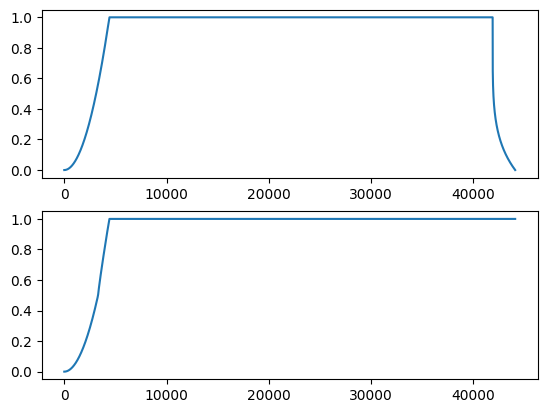

In [34]:
create_adsr("env_woodwind_c", 44100, crop = True, a_len = 0.1, a_exp = 2, d_len = 0.1, d_exp = 0.3, r_len = 0.05, r_exp = 0.2, s_exp = 5, y0 = 0, y1 = 1.0, y2 = 1.0, y3 = 1.0, y4 = 0)
create_adsr("env_woodwind_m", 44100, crop = True, a_len = 0.075, a_exp = 2, d_len = 0.025, d_exp = 0.9, r_len = 0.05, r_exp = 0.2, s_exp = 5, y0 = 0, y1 = 0.5, y2 = 1.0, y3 = 1.0, y4 = 1.0)

plt.subplot(2,1,1)
plt.plot(saved_envelopes["env_woodwind_c"])
plt.subplot(2,1,2)
plt.plot(saved_envelopes["env_woodwind_m"])

Then, multiple filter envelopes are created and combined to give the sound a resonant characteristic for certain frequencies, while still processing it through a lowpass filter. For demonstration purposes, these filters are also adapted for the advanced substractive synthesis, where the spectral phase shift will give the sound a fair amount of "electronic" color.

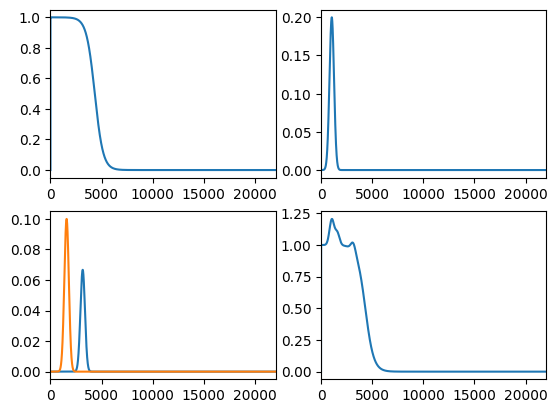

In [35]:
save_filter("filter_lopass_1", "lopass_sig", x_0 = 1575, A_max = 1.5, k = 5)
parameter_to_filter("filter_lopass_1", "filter_lopass_1", 44100)

save_filter("filter_res_1", "gauss_res", x_0 = 1050, A_max = 1.5, A = 0.2, L = 0.02)
parameter_to_filter("filter_res_1", "filter_res_1", 44100)

save_filter("filter_res_2", "gauss_res", x_0 = 3150, A_max = 1.5, A = 0.1/3*2, L = 0.02)
parameter_to_filter("filter_res_2", "filter_res_2", 44100)

save_filter("filter_res_3", "gauss_res", x_0 = 1575, A_max = 1.5, A = 0.1, L = 0.02)
parameter_to_filter("filter_res_3", "filter_res_3", 44100)

combine_filters("filter_lopass_post_1", ["filter_lopass_1", "filter_res_1", "filter_res_2", "filter_res_3"], 44100)


save_filter("filter_lopass_1b", "lopass_sig", x_0 = 1575/4, A_max = 1.5, k = 5)
parameter_to_filter("filter_lopass_1b", "filter_lopass_1b", 11025)

save_filter("filter_res_1b", "gauss_res", x_0 = 1050/4, A_max = 1.5, A = 0.2, L = 0.02)
parameter_to_filter("filter_res_1b", "filter_res_1b", 11025)

save_filter("filter_res_2b", "gauss_res", x_0 = 3150/4, A_max = 1.5, A = 0.1/3*2, L = 0.02)
parameter_to_filter("filter_res_2b", "filter_res_2b", 11025)

save_filter("filter_res_3b", "gauss_res", x_0 = 1575/4, A_max = 1.5, A = 0.1, L = 0.02)
parameter_to_filter("filter_res_3b", "filter_res_3b", 11025)

combine_filters("filter_lopass_post_1b", ["filter_lopass_1b", "filter_res_1b", "filter_res_2b", "filter_res_3b"], 11025)
save_filter("filter_hipass_1b", "lopass_lin", x_min = 1575/4, y_min = 0.75, y_max = 1)
parameter_to_filter("filter_lopass_post_2b", "filter_hipass_1b", 11025)


plt.subplot(2,2,1)
plt.xlim(0,22050)
plt.plot(saved_filters["filter_lopass_1"])
plt.subplot(2,2,2)
plt.xlim(0,22050)
plt.plot(saved_filters["filter_res_1"])
plt.subplot(2,2,3)
plt.xlim(0,22050)
plt.plot(saved_filters["filter_res_2"])
plt.subplot(2,2,3)
plt.xlim(0,22050)
plt.plot(saved_filters["filter_res_3"])
plt.subplot(2,2,4)
plt.xlim(0,22050)
plt.plot(saved_filters["filter_lopass_post_1"])

Afterwards, the perceived frequency is normalized, the modulation frequency is defined using the perceived frequency, the two signals are created and as the final step, the ADSR envelopes are applied. The modulating signal shows an example where the amplitude envelope and an additional frequency modulation are both applied inside the synthesis function, where it is then used for synthesizing the signal that goes into simple substractive filtering. Note that only the last 2 parameters in the list for the fm_1 parameter will be used in this case. For demonstration purposes, the signal that goes into advanced substractive filtering will use a simple sine wave as its modulating signal, which will be defined inside the list.

In [36]:
actual_f = 512
F_instrument_mod = 1.5
f_woodwind = actual_f * F_instrument_mod
f_m_woodwind = f_woodwind / 3 * 2

create_signal("woodwind_m", f_m_woodwind, A = np.asarray(saved_envelopes["env_woodwind_m"]), phi = 1 + signal(1, "squ", A = 5, phi = 0.25))
create_signal("woodwind_c_1", f_woodwind, fm_1 = [1, "woodwind_m", 1, 1, True, 2], filter_type = 1, filter_1 = "filter_lopass_post_1")
create_signal("woodwind_c_2", f_woodwind, fm_1 = [f_m_woodwind, "sin", 1, 1, True, 2], filter_type = 2, filter_1 = "filter_lopass_post_1b", filter_2 = "filter_lopass_post_2b")
apply_envelope("woodwind1", "woodwind_c_1", "env_woodwind_c")
apply_envelope("woodwind2", "woodwind_c_2", "env_woodwind_c")

C:\Users\brj\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
C:\Users\brj\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


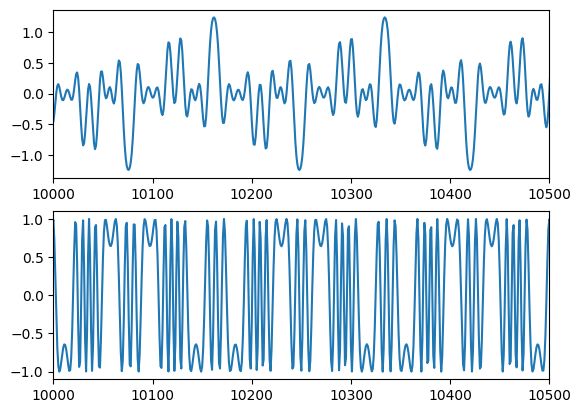

In [37]:
plt.subplot(2,1,1)
plt.xlim(10000,10500)
plt.plot(saved_signals["woodwind1"])
plt.subplot(2,1,2)
plt.xlim(10000,10500)
plt.plot(saved_signals["woodwind2"])

Lastly, audio files are created for the purposes of listening to the sounds created.

In [38]:
write("woodwind1.wav", fsample, (saved_signals["woodwind1"]).astype(np.float32))
ipd.Audio(r"woodwind1.wav")

C:\Users\brj\AppData\Local\Temp\ipykernel_35580\2043802362.py:1: ComplexWarning: Casting complex values to real discards the imaginary part
  write("woodwind1.wav", fsample, (saved_signals["woodwind1"]).astype(np.float32))


In [39]:
write("woodwind2.wav", fsample, (saved_signals["woodwind2"]).astype(np.float32))
ipd.Audio(r"woodwind2.wav")

For further reading:
- On frequency modulation and phase modulation
    - J. M. Chowning (1973), "The Synthesis of Complex Audio Spectra by Means of Frequency Modulation", Journal of the Audio Engineering Society, 21(7), p. 526–534.
    - https://dspfirst.gatech.edu/chapters/03spect/demos/fmsynth/index.html
    - https://www.gwoptics.org/learn/02_Plane_waves/03_Optical_modulation/01_Phase_and_frequency_modulation.php
- On the frequency responses of amplitude and phase in Bode plots
    - https://lpsa.swarthmore.edu/Bode/Bode.html